# Project Milestone 01 (NE 591) - Serial neutron diffusion code
- **Author**: Kirill Shumilov
- **Date**: Thu, Feb 14, 2025

# 0. Analysis Code Setup

In [1]:
import json
import pathlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from dataclasses import dataclass, asdict, field


defaults = dict(X = 1, Y = 1, D = 1, S = 1, Q = 1)


@dataclass
class Problem:
    X: float = defaults['X']
    Y: float =  defaults['Y']
    NX: int = 1
    NY: int = 1
    D: float = defaults['D']
    S: float = defaults['S']
    q: np.ndarray = field(default_factory=lambda: np.zeros((1, 1), dtype=np.float64))

    @classmethod
    def from_json(cls, filename) -> 'Problem':
        with open(filename, 'r') as f:
            j = json.load(f)

        return cls.from_dict(j)

    @classmethod
    def from_dict(cls, j):
        return cls(
            j['grid']['space']['X'], 
            j['grid']['space']['Y'],
            j['grid']['points']['NX'], 
            j['grid']['points']['NY'], 
            j['absorption_scattering'],
            j['diffusion_coefficient'],
            np.asarray(j['source']['m_data']).reshape(j['source']['m_rows'], j['source']['m_cols'])
        )

    def to_dict(self):
        d = {
            'grid': {
                'space': {'X': self.X, 'Y': self.Y},
                'points': {'NX': self.NX, 'NY': self.NY},
            },
            'absorption_scattering': self.D,
            'diffusion_coefficient': self.S,
            'source': {
                'm_rows': self.q.shape[0],
                'm_cols': self.q.shape[1],
                'm_data': self.q.flatten().tolist()
            }
        }

        return d

    def to_json(self, filename: str):
        with open(filename, 'w') as f:
            json.dump(self.to_dict(), f)


@dataclass
class Solution:
    prob: Problem
    flux: np.ndarray
    residual: np.ndarray

    @classmethod
    def from_json(cls, filename) -> 'Problem':
        with open(filename, 'r') as f:
            j = json.load(f)

        return cls(
            Problem.from_dict(j['problem']),
            np.asarray(j['flux']['m_data']).reshape(j['flux']['m_rows'], j['flux']['m_cols']),
            np.asarray(j['residual'])
        )

# 1. Description of Work
In this project milestone, we have implemented the steady state, one speed diffusion equation in a non-multiplying, isotropic scattering homogeneous medium, in a two-dimensional rectangular region, under vaccum boundary conditions on all four sides. To achieve this goal the following steps have been taken.

Steps Taken:
------------
1) Read & validate the input from the file.

Make sure that the following invariants are true throughout the exectuation of the code.
- Positive $a$ & $b$
- $N\ \&\ M > 0$
- $D > 0$ and $\Sigma_a > 0$


2) Construct the operator. To find the solution to the steady-state of the system we use under the edge-centered finite-difference method to discretize the diffusion operator. Thus a matrix form of the operator, $A(D, \Sigma_a)$, and RHS vector, $b(q)$, must be found. The linear set of equations
\begin{equation}
-D\left[\frac{\phi_{i+1,j}-2\phi_{i,j}+2\phi_{i+1,j}}{\delta^2} + \frac{\phi_{i,j-1}-2\phi_{i,j}+2\phi_{i,j + 1}}{\gamma^2}\right] + \Sigma_a\phi_{i,j} = q_{ij}
\end{equation}
are cast such that diagonal elements of the matrix are equal to $2D(\frac{1}{\delta^2} + \frac{1}{\gamma^2}) + \Sigma_a$ and off diagonal elements are $-D\frac{1}{\delta^2}$ or $-D\frac{1}{\gamma^2}$, dending on the positive of the cell w.r.t. to the edge of the box.

3) Decompose $A$ using LUP Factorization, solve $Ax=b$ or $PA=LUx=Pb$ for $x$, which in our case is $\phi_{ij}$, and find the residual $r=b - LUx$ to check correctness

# 2. Numerical Experiments

To check correctness of the calculation two experiments have been conducted. The examples of input files, output files, and aggregated data is stored under `examples/` directories.

## Grid Size

By varying grid size of the system we checked that as $N,M$-number of grid-points increased the solution coverged to a circularly symmetric "blur-like" solution. Not only the this experiment allows to check whehter the solution is improves with grid size, but also allows to profile and test execution time scaling. Specifically the point source of intensity $1$ was fixed in the middle of the rectange. Systems with 4, 8. 16, 32, and 64 points along each dimension were tested. The hypothesis is that the solution will be circular, with increasing smoothness as grid size grows. The execution time should increase cubicallly with system size, while memory used should increase quadratically.

In [3]:
def generate_point_problem(N, X, Y, D, S, Q):
    Qx, Qy = N // 2, N // 2

    q = np.zeros((N, N), dtype=np.float64)
    q[Qx, Qy] += Q

    return Problem(
        X, Y, N, N, D, S,
        q=q,
    )

In [4]:
def vary_grid_size(N):
    problems = {}

    for n in N:
        p = problems[n] = generate_point_problem(n, **defaults)
        p.to_json(f'examples/p{n}.json')

In [5]:
N = [4, 8, 16, 32, 64]
vary_grid_size(N)

## Shape

Second Experiment involved testing whether a line point source provides a solution that is congruent with sources's symmetry. In particular a line of sources has been set horizontally in the middle of the recangle. It should be obsreved that the solution should also obey this symmetry.

In [6]:
def generate_line_problem(N, X, Y, D, S, Q):
    Qx = N // 2

    q = np.zeros((N, N), dtype=np.float64)
    q[Qx] += Q

    return Problem(
        X, Y, N, N, D, S,
        q=q,
    )

p = generate_line_problem(64, **defaults)
p.to_json('examples/l64.json')

# 3. Results

## Grid Size

In [7]:
def plot_n(n, ax):
    s = Solution.from_json(f'examples/p{n}_result.json')
    img = ax.imshow(s.flux, cmap='viridis')  # Use 'viridis' colormap


    # Add labels and title (optional)
    ax.set_xlabel("X-axis")
    ax.set_ylabel("Y-axis")
    ax.set_title(f"Point Source ({n}x{n})")

    return img

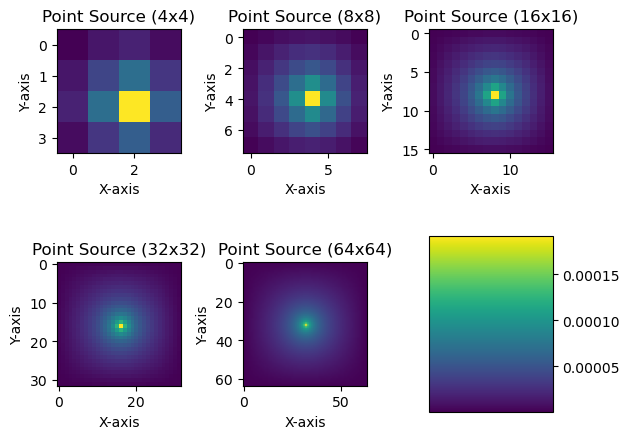

In [8]:
fig, axes = plt.subplots(2, 3, tight_layout=True)

plot_n(4, axes[0, 0])
plot_n(8, axes[0, 1])
plot_n(16, axes[0, 2])
plot_n(32, axes[1, 0])
img = plot_n(64, axes[1, 1])


# Add a colorbar for reference
plt.colorbar(img, cax=axes[1, 2])

# Show the plot
plt.show()

From the graphs, above we can see that as the grid size is increased, the image becomes cleared, but theoverall shape of the solution does not change. The solution becomes more refined as expected.

## Scaling Analysis

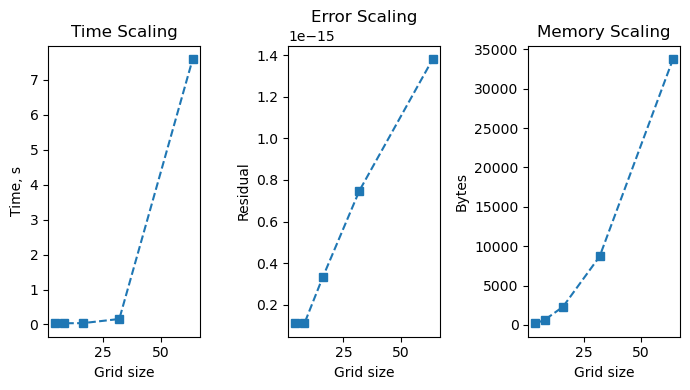

In [9]:
df = pd.read_csv('examples/data.csv')

fig, axes = plt.subplots(1, 3, tight_layout=True, sharex=True, figsize=(7, 4))

axes[0].plot('n', 'time', 's--', data=df)
axes[1].plot('n', 'residual', 's--', data=df)
axes[2].plot('n', 'mem_est','s--', data=df)

axes[0].set_xlabel('Grid size')
axes[1].set_xlabel('Grid size')
axes[2].set_xlabel('Grid size')

axes[0].set_ylabel('Time, s')
axes[1].set_ylabel('Residual')
axes[2].set_ylabel('Bytes')

axes[0].set_title('Time Scaling')
axes[1].set_title('Error Scaling')
axes[2].set_title('Memory Scaling')

fig.suptitle

plt.show()

From the graphs above we can se expected polynomial scaling in time and memory. The scaling in residual is roughly linear and increasing, even though it is extremely small altogether. which is counterintuitive. However, it can be explained by the accumulated numerical error of the LUP factorization that is "picked-up" at each iteration.

## Line Source

As can be seen from the graph below, the solution for the line-source adheres to the expectation, indicating that the implementation is correct.

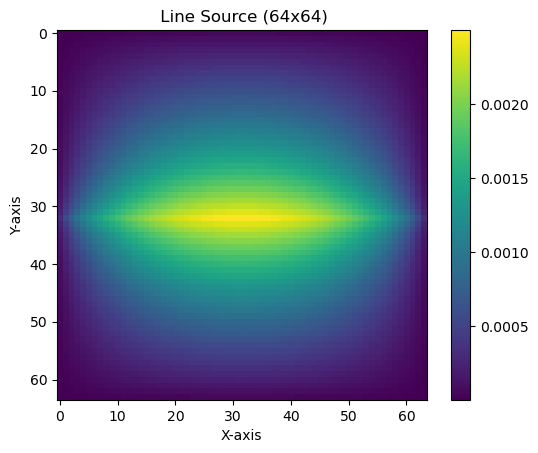

In [11]:
s = Solution.from_json('examples/l64_result.json')

# Create the heatmap
plt.imshow(s.flux, cmap='viridis')  # Use 'viridis' colormap

# Add a colorbar for reference
plt.colorbar()

# Add labels and title (optional)
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title(f" Line Source ({64}x{64})")

# Show the plot
plt.show()

# 4. Discussion

As can be seen from the result, the `LUPSolver` for the given diffusion problem works and provides a physically correct soltuion. Both geomtries of tested provide expected solutions, respecting the symmetry of the initial source.

The execution time of the code grows polynomially. For small systems, it is nearly flat, as the small matrices fit nicely into caches of the system. However, the larger the grid size, the larger is memory requriement, the more frequent are the "cache-misses" and the execution time grows signficiantly. For the grid point source on the grid size of 128x128, the program takes minutes to execute thand is not shown here.

A more detailed profiling of the code, shows that a lot of the time is spent searching for the pivot in the LUP factorization and in the update of the matrix. Since the matrix is diagonally-dominant and is very sparse, the program spends a lot of time dividing zeros by some numbers, obtaining zeros, which is wasteful. A better pivoting stratergy and "matrix-vector multiplication" implementatiuon, taking advantage of the internal structure of the matrix would allow for much more performant code.

# 5. Conclusion

In this work, we implemented the steady state, one speed diffusion equation in a non-multiplying, isotropic scattering homogeneous medium, in a two-dimensional rectangular region, under vaccum boundary conditions on all four sides and its solver using LUP factoriztion. The code is functional and provides physically correct solutions for given systems. 

However, the algorithm chosen is very simplistic. It is not using the internal structure of the linear operator used to solve the system. This mismatch results in poor performace for larger systems. On the flip side, the implementation is straigtforward and easy. Therefore, it can be used as a baseline benchmark implementation for future improved solutions.